In [1]:
from param import Param
from sde import *
import numpy as np

In [2]:
# Euler's Discretization
mu  = lambda S_t, t: S_t
v   = lambda S_t, t: .6 * S_t
S_0 = Param(100)
T   = 252
dt  = Param(0.01)
N   = 20

simulation = EulerSimulation(mu, v, S_0, T, dt, N)
simulation.run_all()

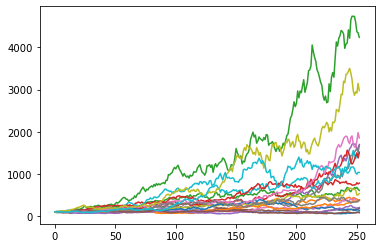

In [3]:
from matplotlib import pyplot as plt

simulation.run_new(20)
for i in range(N):
    plt.plot(simulation.results[:, i])
plt.show()

In [4]:
# Log Euler's Discretization
mu  = lambda S_t, t: 1
v   = lambda S_t, t: .6
S_0 = Param(100)
T   = 252
dt  = Param(0.01)
N   = 20

simulation = EulerSimulation(mu, v, S_0, T, dt, N, param=LogEulerParam)
simulation.run_all()

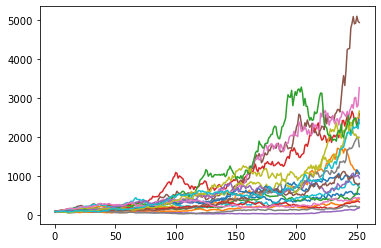

In [5]:
from matplotlib import pyplot as plt

simulation.run_new(20)
for i in range(N):
    plt.plot(simulation.results[:, i])
plt.show()